# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats as st

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

temp = [data_0, data_1, data_2]

Пропусков в данных не наблюдаются, всё приведено к нужному типу; Следует удалить столбец `'id'`, т.к. он не повлияет на дальнейшее обучение модели

In [8]:
print('повторов до:', data_0['id'].duplicated().sum())
data_0 = data_0.drop_duplicates(subset='id')
print('повторов после:', data_0['id'].duplicated().sum())

повторов до: 10
повторов после: 0


In [9]:
print('повторов до:', data_1['id'].duplicated().sum())
data_1 = data_1.drop_duplicates(subset='id')
print('повторов после:', data_1['id'].duplicated().sum())

повторов до: 4
повторов после: 0


In [10]:
print('повторов до:', data_2['id'].duplicated().sum())
data_2 = data_2.drop_duplicates(subset='id')
print('повторов после:', data_2['id'].duplicated().sum())

повторов до: 4
повторов после: 0


=> Неявные дубликаты убраны, можно избавляться от столбца `'id'`

In [11]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

**Вывод:** Все данные подготовлены к дальнейшему разделению на выборки и обучению модели линейной регрессии. Перед эти данные следует привести к нужному масштабу

In [13]:
l = 0
for i in temp:
    l += 1
    print(f'data {l}:')
    display(i.sample(5))
    print()
    i.info()
    print()
    display(i.describe())
    print()
    display(i.corr())
    print()

data 1:


,id,f0,f1,f2,product
4329,J5ZnX,0.688832,-0.384627,3.778974,23.957896
85418,uaIxa,-0.891097,0.556103,0.229408,80.548890
5209,AcXED,0.294901,0.834816,6.986397,137.700081
13502,Tuint,0.220420,0.013442,-0.850075,67.729529
42832,5sS54,0.111879,0.508964,1.223774,29.015684



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000



data 2:


,id,f0,f1,f2,product
37827,xhTAK,7.782877,-6.828489,3.005489,80.859783
12202,oArEp,0.712556,-6.121589,3.003089,84.038886
40512,Tnulu,1.422351,-1.190580,1.995364,57.085625
6133,LhSeU,-4.839135,-8.309974,4.003618,110.992147
86403,GoWoU,-2.513564,-0.706346,1.001103,30.132364



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000



data 3:


,id,f0,f1,f2,product
84502,3vzQl,0.850837,-2.400590,3.165892,92.556201
66794,yQ5x0,-0.214015,1.929601,3.799654,108.123406
46599,XivVN,0.613155,-0.018477,0.167060,120.786482
99016,JXJEq,-0.629532,-1.556810,4.095556,120.739021
15275,hq6rG,-1.114083,-1.257832,8.075840,119.567887



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


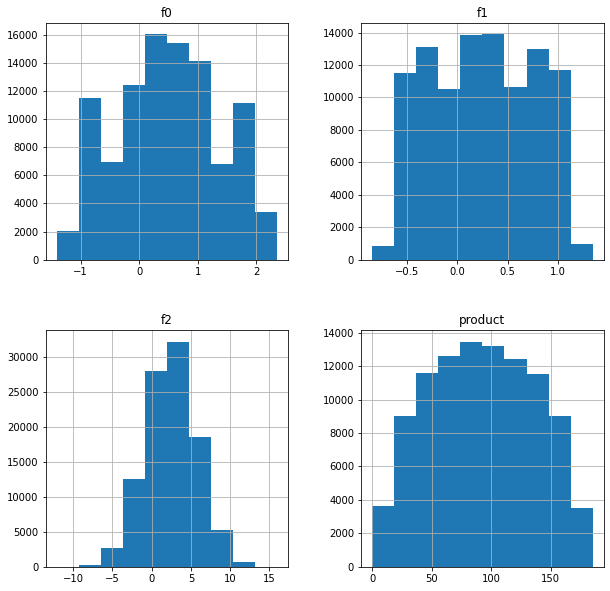

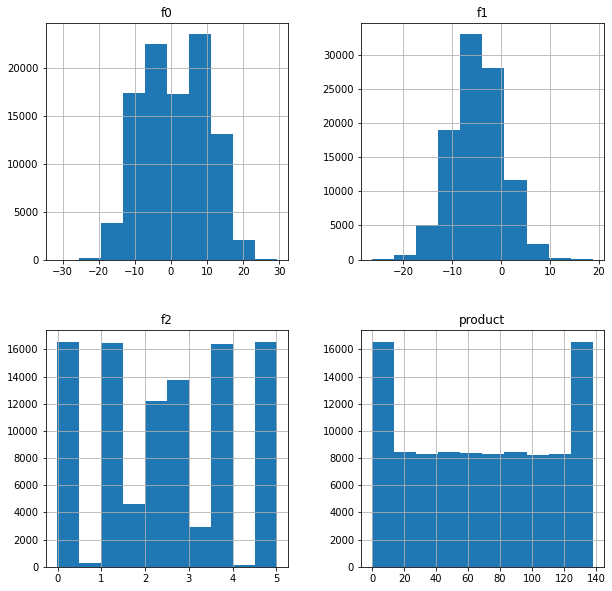

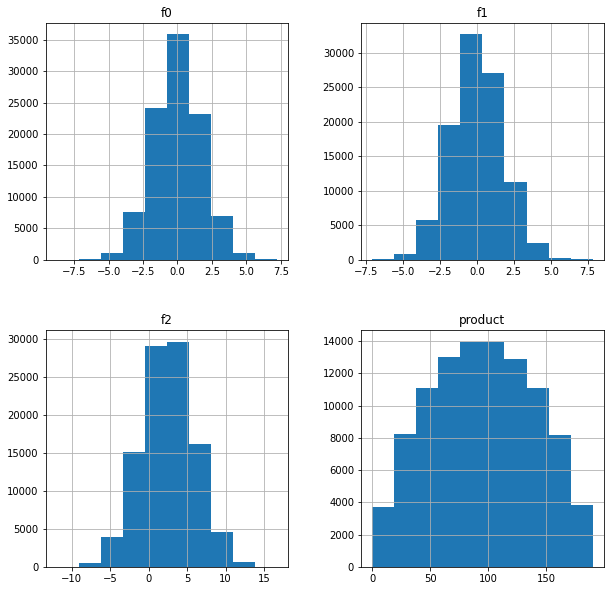

In [14]:
for i in temp:
    i.hist(figsize=(10, 10))

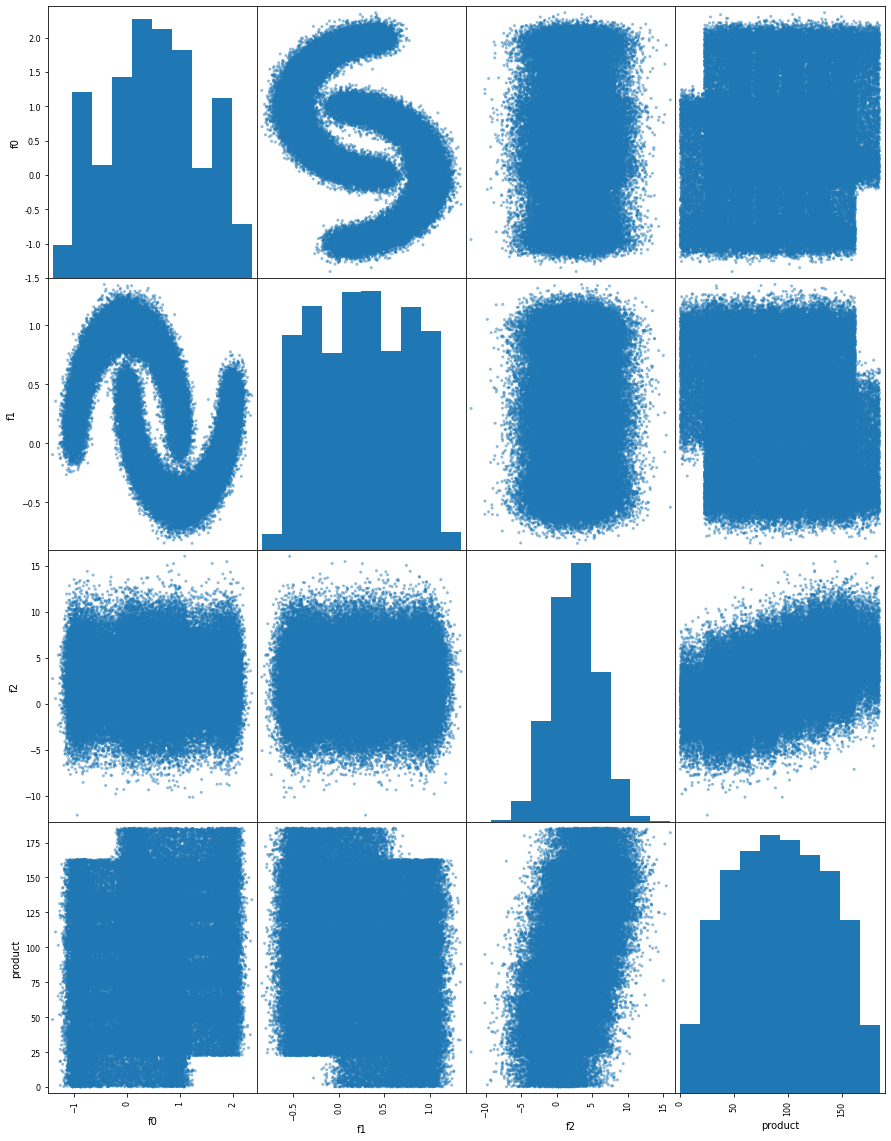

In [15]:
_ = pd.plotting.scatter_matrix(data_0, figsize=(15, 20))

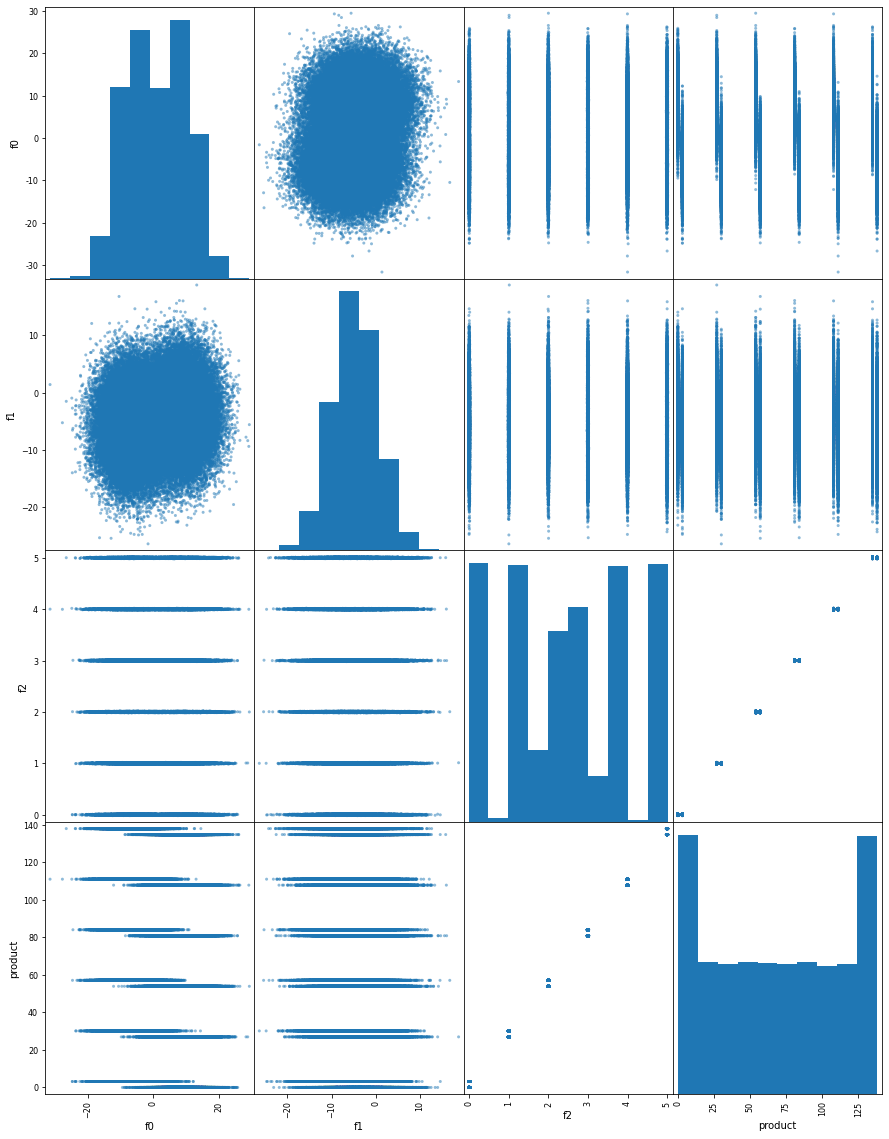

In [16]:
_ = pd.plotting.scatter_matrix(data_1, figsize=(15, 20))

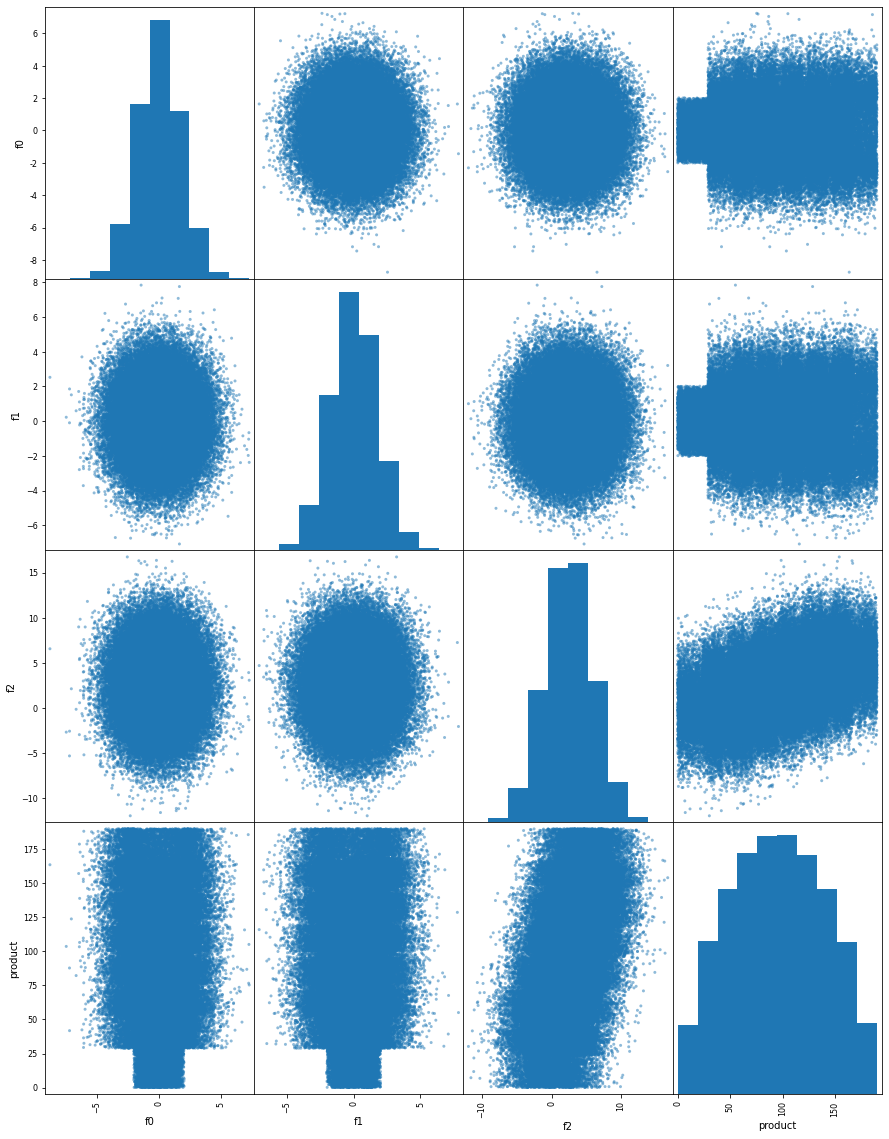

In [17]:
_ = pd.plotting.scatter_matrix(data_2, figsize=(15, 20))

## Обучение и проверка модели

Разделить данные на нужные выборки и привести к нужному масштабу предстоит сразу в трёх датасетах, поэтому удобнее будет написать функцию, осуществляющую эту процедуру универсально:

In [18]:
def split(df):
    features = df.drop('product', axis=1)
    target = df['product']
    
    features_train, features_valid, \
    target_train, target_valid = train_test_split(features, target, 
                                                  test_size=0.25, random_state=1012)

    numeric = ['f0', 'f1', 'f2']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    return features_train, features_valid, target_train, target_valid   

In [19]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = split(data_0)
features_train_1, features_valid_1, target_train_1, target_valid_1 = split(data_1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split(data_2)

In [20]:
print(features_train_0.shape)
print(features_valid_0.shape)
print(target_train_0.shape)
print(target_valid_0.shape)

(74992, 3)
(24998, 3)
(74992,)
(24998,)


=> Данные разделены корректно, в соотношении 3:1

Для удобного обучения модели линейной регрессии каждого датасета следует также написать функцию:

In [21]:
def modeling(features_train, features_valid, target_train, target_valid, num):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = pd.Series(model.predict(features_valid))
    
    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    mean_pred_pr = predictions_valid.mean()
    
    print(f'Регион {num}:')
    print(f'Средний запас предсказанного сырья: {mean_pred_pr}')
    print(f'RMSE модели: {rmse}')
    print()
    
    return predictions_valid, rmse, mean_pred_pr

In [22]:
predictions_valid_0, rmse_0, mean_pred_pr_0 = modeling(features_train_0, features_valid_0, target_train_0, target_valid_0, 1)
predictions_valid_1, rmse_1, mean_pred_pr_1 = modeling(features_train_1, features_valid_1, target_train_1, target_valid_1, 2)
predictions_valid_2, rmse_2, mean_pred_pr_2 = modeling(features_train_2, features_valid_2, target_train_2, target_valid_2, 3)

Регион 1:
Средний запас предсказанного сырья: 92.50932999857729
RMSE модели: 37.761835912077935

Регион 2:
Средний запас предсказанного сырья: 69.16374462496539
RMSE модели: 0.8901743300092636

Регион 3:
Средний запас предсказанного сырья: 95.01363982583379
RMSE модели: 40.04440310216543



**Вывод:**
* Данные корректно разделены на выборки в пропорции 3:1
* Для каждого региона была в отдельности обучена модель линейной регрессии
* Предсказания на моделях для регионов 1 и 3 выдали примерно одинаковый результат согласно метрике RMSE

## Подготовка к расчёту прибыли

Введём функцию для удобного отображения больших чисел в рублях:

In [23]:
def num_print(num):
    temp = ''
    l = 0
    for i in str(round(num)):
        l += 1
        temp += i
        if l % 3 == 0:
            temp += ' '
    
    print(temp + ' руб.')

Введём константы согласно условию:

In [24]:
Research = 500 # количество точек для исследования
Mining = 200 # количество точек для разработки
Mining_Budget = 10_000_000_000 # бюджет на разработку скважин в регионе
Revenue_Per_Barrel = 450_000 # доход с 1 тыс. баррель
Loss_Probability = 0.025 # максимальная вероятность убытков
Samples = 1000 # количество выборок для bootstrap

Затраты на разработку одной скважины:

In [25]:
borehole_budget = Mining_Budget / Mining
num_print(borehole_budget)

500 000 00 руб.


Необходимый объем сырья для безубыточной разработки 1 скважины в тыс. баррелей:

In [26]:
sufficient_product_volume = borehole_budget / Revenue_Per_Barrel
round(sufficient_product_volume)

111

**Вывод:** Необходимый объем сырья для того, чтобы разработка скважины была окупаемой составил 111 тыс. баррелей, что сильно больше среднего запаса предсказанного сырья

## Расчёт прибыли и рисков 

In [27]:
def profit(target, pred):
    pred_choice = pred.sort_values(ascending=False).head(Mining)
    target_choice = target.reset_index(drop=True)[pred_choice.index]
    income = target_choice.sum() * Revenue_Per_Barrel
    
    return income

In [28]:
print('Прибыль в с 200 выбранных по предсказаниям модели скважин составит:')
print(f'\nрегион 1:', end=' ')
num_print(profit(target_valid_0, predictions_valid_0) - Mining_Budget)

print(f'регион 2:', end=' ')
num_print(profit(target_valid_1, predictions_valid_1) - Mining_Budget)

print(f'регион 3:', end=' ')
num_print(profit(target_valid_2, predictions_valid_2) - Mining_Budget)

Прибыль в с 200 выбранных по предсказаниям модели скважин составит:

регион 1: 337 169 058 3 руб.
регион 2: 241 508 669 7 руб.
регион 3: 271 652 954 9 руб.


In [29]:
def revenue (target_valid, predictions_valid, mining_count):
    pred_choice = predictions_valid.sort_values(ascending=False)
    target_choice = target_valid[pred_choice.index][:mining_count]
    income = target_choice.sum() * Revenue_Per_Barrel
    return income

Вынесем бутстреп в отдельную функцию:

In [30]:
def boot_strap(predictions_valid, target_valid, bootstrap_samples, explore_count):
    state = np.random.RandomState(1012)
    values = []
    
    for i in range(bootstrap_samples):
        target_subsample = target_valid.reset_index(drop=True).sample(explore_count, replace=True, random_state=state)
        probs_subsample = predictions_valid[target_subsample.index]
        rev = revenue(target_subsample, probs_subsample, Mining) - Mining_Budget
        values.append(rev)

    return pd.Series(values)

95% Доверительный интервал:

In [31]:
def income_distribution (predictions_valid, target_valid, bootstrap_samples, explore_count):
    values = boot_strap(predictions_valid, target_valid, bootstrap_samples, explore_count)
    
    mean_value = values.mean()
    print("Средняя выручка:", end=' ')
    num_print(round(mean_value))

    lower_bound = round(pd.Series(values).quantile(0.025))
    upper_bound = round(pd.Series(values).quantile(0.975))
    print(f"95% доверительный интервал: ({lower_bound}, {upper_bound})")

    pvalue = (values < 0).mean()
    if pvalue < Loss_Probability:
        print("Вероятность убытков {:.2%} является меньше допустимой => регион подходит по критериям".format(pvalue))
    else:
        print("Вероятность убытков {:.2%} является больше допустимой => регион не подходит по критериям".format(pvalue))

In [32]:
print('Результаты по региону 1:')
income_distribution(predictions_valid_0, target_valid_0, Samples, Research)
print('\nРезультаты по региону 2:')
income_distribution(predictions_valid_1, target_valid_1, Samples, Research)
print('\nРезультаты по региону 3:')
income_distribution(predictions_valid_2, target_valid_2, Samples, Research)

Результаты по региону 1:
Средняя выручка: 487 646 525  руб.
95% доверительный интервал: (-32238201, 1029444096)
Вероятность убытков 3.50% является больше допустимой => регион не подходит по критериям

Результаты по региону 2:
Средняя выручка: 537 286 174  руб.
95% доверительный интервал: (102148581, 958714923)
Вероятность убытков 0.90% является меньше допустимой => регион подходит по критериям

Результаты по региону 3:
Средняя выручка: 420 808 668  руб.
95% доверительный интервал: (-177894391, 934786216)
Вероятность убытков 8.30% является больше допустимой => регион не подходит по критериям


**Вывод:**
* Согласно вероятности убытков, для добычи подходит лишь второй регион
* Второй регион самый прибыльный с точки зрения средней выручки
* Левая граница доверительного интервала первого и третьего регионов лежит левее нуля, что подтверждает их неактуальность